# Introduction
In this notebook I am going to explain the steps that I would follow to build a binary image classifier.

This challenge is a classic (cats and dogs) classification task, where the classes are ballanced.

Four approahes are proposed in a gradual order (from simple to more complex), the goal is to explain the principles of image classification with Convolutional neural networks (CNN), and to compare the results of different classifiers.

## Remarks
* The solution is not complete, more thourough investigations are needed to optimise the results and to more understand the dataset characteristics.
* The results will be discussed and follow-up steps will be proposed when necessary.


## Technical specifications

* I am using Keras with tensorflow-gpu back-end.

* The code is executed on an AWS EC2 p2.xlarge instance, using Deep Learning AMI image (https://aws.amazon.com/machine-learning/amis/).

* To run notebook on your own machine please create a virtual environment with python 3.6.x, and install:
  * tensorflow (if CPU `pip install tensorflow`, if GPU `pip install tensorflow-gpu`).
  * keras
  * matplotlib
  * pillow
  * pandas

* To run this notebook in the virtual environment:

 * activate the virtual environment (`source projectname/bin/activate`)
 
 * `(venv) $ pip install ipykernel`
 
 * `(venv) $ ipython kernel install --user --name=projectname`
 
 * start jupyter notebook and you can select the virtual environment from the Kernel menu (Kernel -> change kernel)

In [7]:
# To display and store the plots within the notebook.
%matplotlib inline

# Step 1: Preparing the directories and splitting the data

For the details, please check the comments in the code cells

In [8]:
import os

# Path to the base data directory that contains Cows and Chickens sub-directories
# In this case, this based directory is located in the same directory of the notebook
base_dir = "data"


####### Create the train directory with cows and chickens sub-directories inside it #######
### To protect any pre-existing data, the following lines of code #####
#### will yiel an exception if any directory already exists #####


train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

train_cows_dir = os.path.join(train_dir, 'cows')
os.mkdir(train_cows_dir)

train_chicken_dir = os.path.join(train_dir, 'chickens')
os.mkdir(train_chicken_dir)

####### Create the validation directory with cows and chickens sub-directories inside it #######

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

validation_cows_dir = os.path.join(validation_dir, 'cows')
os.mkdir(validation_cows_dir)

validation_chickens_dir = os.path.join(validation_dir, 'chickens')
os.mkdir(validation_chickens_dir)

####### Create the test directory with cows and chickens sub-directories inside it #######

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

test_cows_dir = os.path.join(test_dir, 'cows')
os.mkdir(test_cows_dir)

test_chickens_dir = os.path.join(test_dir, 'chickens')
os.mkdir(test_chickens_dir)

In [9]:
# Build a list of the full path to all images (.jpg) in the dataset
file_paths = []
others = []
for dirname, dirnames, filenames in os.walk(base_dir):
    for filename in filenames:
        if ".jpg" in filename.lower():
            file_paths.append(os.path.join(dirname, filename))
        else:
            others.append(os.path.join(dirname, filename))

In [10]:
# Build two sub-lists, one for the paths to the cows images and another for the paths to the chickens images
# I am shuffling the sub-lists to avoid any pre-order that could happen when reading the paths from the base directory

from random import shuffle

cows_img_pathes = list(filter(lambda k: 'Cows' in k, file_paths))
shuffle(cows_img_pathes)

chickens_img_pathes = list(filter(lambda k: 'Chickens' in k, file_paths))
shuffle(chickens_img_pathes)

In [11]:
import math

# A function to split the a list of pathes into three sub-lists, training, validation and test
# The full list and the train and validation ratios are passed as input parameters
def train_val_test_split(full_list, train_ratio, val_ratio):
    toal_sample_num = len(full_list)
    
    train_num = int(math.floor(toal_sample_num * train_ratio))
    val_num = int(math.floor(toal_sample_num * val_ratio))
    
    train_list = full_list[0:train_num]
    val_list = full_list[train_num:train_num+val_num]
    test_list = full_list[train_num+val_num:]
    
    return train_list, val_list, test_list


# Split each of the cows images list and the chickens images list into train, val and test
# The same ratios are used to maintain the same distribution of classes in the training, validation and test sets.

train_cows, val_cows, test_cows = train_val_test_split(cows_img_pathes, 0.8, 0.1)
train_chickens, val_chickens, test_chickens = train_val_test_split(chickens_img_pathes, 0.8, 0.1)

train_paths = train_cows+train_chickens
val_paths = val_cows+val_chickens
test_paths = test_cows+test_chickens

train_samples_num = len(train_paths)
val_samples_num = len(val_paths)
test_samples_num = len(test_paths)


# Make sure that the training, validation and test sets are disjoints
assert(not bool(set(train_paths) & set(val_paths)))
assert(not bool(set(val_paths) & set(test_paths)))
assert(not bool(set(train_paths) & set(test_paths)))

In [12]:
import shutil

# A function to copy the files referenced in a list of paths into a distination diretory
def copy_to_directory(pathes_list, dir_path):
    for file_path in pathes_list:
        file_name = file_path.split("/")[-1]
        if ".jpg" in file_name.lower():
            dst = os.path.join(dir_path, file_name)
            shutil.copyfile(file_path, dst)


# calling the previous function to copy the the the training, validation and test images into their directories
copy_to_directory(train_cows, train_cows_dir)
copy_to_directory(val_cows, validation_cows_dir)
copy_to_directory(test_cows, test_cows_dir)

copy_to_directory(train_chickens, train_chicken_dir)
copy_to_directory(val_chickens, validation_chickens_dir)
copy_to_directory(test_chickens, test_chickens_dir)

In [13]:
# A helper function to "pretty" print a directory hierarchy with the number of images in each sub-directory

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        filtered_names = list(filter(lambda k: '.jpg' in k.lower(), files))
        if len(filtered_names) > 0:
            print('{}{} -- ({} images)'.format(indent, os.path.basename(root), len(filtered_names)))
        else:
            print('{}{}'.format(indent, os.path.basename(root)))

# Print the full hierarchy of our data

list_files("data")

data
    train
        chickens -- (1584 images)
        cows -- (1641 images)
    validation
        chickens -- (198 images)
        cows -- (205 images)
    Chickens -- (1980 images)
    Cows -- (2052 images)
    test
        chickens -- (198 images)
        cows -- (206 images)


# First approach: Simple Convolutional Neural Network

* At this stage we have the directory hierarchy with all training, validation and test images, we are ready to build our first CNN.

* The proposed basic CNN archetecture is a stack of four alternated Conv2D (with relu activation) and MaxPooling2D layers. The alteration of Conv2D and MaxPooling2D is a standard option to start with.


* It is challenging to choose a suitable architecture for image classification tasks. So for demonstration perpuse, I am adopting a very simple architecture used for basic tests in "Francois Chollet - Deep Learning with Python-Manning Publications (2017)".

* In the input layer, we start from input images of size 150 × 150 (Keras will automatically scale the input images to the specified dimensions), and we end up with feature maps of size 7 × 7.

* We feed the last output feature map (of shape (7, 7, 128)) into a densely connected classifer layer, by first flatten the 3D outputs to 1D vectors (of 6272 dimensions each), and then add feed these vectors to a Dense layer.

* Because we have a binary classification task, the last layer has a single unit (a Dense layer of size 1) with sigmoid activation. This unit will output the probability of having one class or the other.

## Model

In [109]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [110]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 15, 15, 128)       147584    
__________

## Configure the model for training

For binary classification problems, the `binary_crossentropy` is a suitable loss function to minimise, and the classification accuracy `acc` is a suitable metric to report.

### Remark on the learning rate
* The learning rate (1e-4) is used to limit the magnitude of the modifications while fine-tuning.
* In a normal context, this parameter should be tuned to find the optimal value that lead to the best results on the validation set. As the time is limited in this challenge, I only evaluated 1e-4 and 1e-5, they led to very close results while the 1e-4 converged quicker.

In [18]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [19]:
from keras.preprocessing.image import ImageDataGenerator

# Rescale the pixel values (between 0 and 255) to the [0, 1] interval
# The goal behind the scaling is to make the learning easier and
# to avoid triggering large gradient updates preventing the network form diverging.

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)


# Use flow_from_directory function that takes the path to a directory & generates batches of data.
# Here a isngle data augmentation is applied to unify the sizes of images.
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=32,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(150, 150),
                                                              batch_size=32,
                                                              class_mode='binary')

Found 3225 images belonging to 2 classes.
Found 403 images belonging to 2 classes.


### Remark on the target_size
* The re-sizing the images into squares of 150 x 150 is arbitrary and selected to have a tracktable final feature map
* More experiments are necessary to tune this factor.

## Train the first model

In [20]:
history1 = model.fit_generator(train_generator,
                               steps_per_epoch=100, # with batch_size of 32 and steps_per_epoch=100 we iterate cover almost all training data (3225 samples)
                               epochs=50,
                               validation_data=validation_generator,
                               validation_steps=15, # with batch_size=32 and validation_stpes=15 we cover all validation data (403 samples)
                               use_multiprocessing=True, # To maximise the usage of the GPU and memory
                               workers=8)

Epoch 1/50
100/100 [==============================] - 67s 674ms/step - loss: 0.6152 - acc: 0.6462 - val_loss: 0.4860 - val_acc: 0.7987
Epoch 2/50
100/100 [==============================] - 19s 193ms/step - loss: 0.5035 - acc: 0.7598 - val_loss: 0.4595 - val_acc: 0.7880
Epoch 3/50
100/100 [==============================] - 19s 190ms/step - loss: 0.4545 - acc: 0.7879 - val_loss: 0.5420 - val_acc: 0.7388
Epoch 4/50
100/100 [==============================] - 19s 195ms/step - loss: 0.4214 - acc: 0.8067 - val_loss: 0.4024 - val_acc: 0.8158
Epoch 5/50
100/100 [==============================] - 19s 194ms/step - loss: 0.3992 - acc: 0.8185 - val_loss: 0.4218 - val_acc: 0.7859
Epoch 6/50
100/100 [==============================] - 20s 196ms/step - loss: 0.3754 - acc: 0.8382 - val_loss: 0.3632 - val_acc: 0.8415
Epoch 7/50
100/100 [==============================] - 19s 193ms/step - loss: 0.3588 - acc: 0.8447 - val_loss: 0.3930 - val_acc: 0.8351
Epoch 8/50
100/100 [==============================] - 1

In [21]:
model.save('cows_and_chickens_model_1.h5')

In [22]:
# Helper function to draw the training/validation accuacy and loss graphs
import matplotlib.pyplot as plt

def plot_loss_acc_graph(model_history):
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

## Plotting the training/validation accuracy and loss graphs

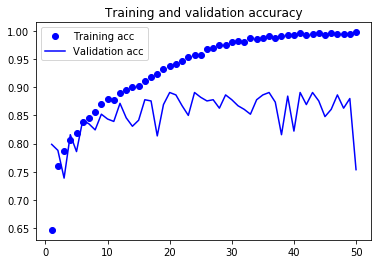

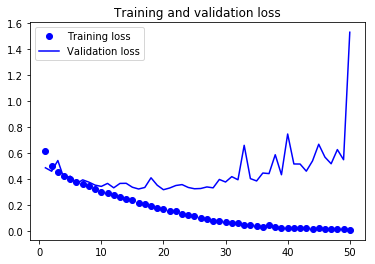

In [23]:
plot_loss_acc_graph(history1)

## Disucssion

* The graph show clearly an overfitting case where after about 15 epochs the accuracy on the validation set will no longer enhance (it will stay around 0.88) and the validation loss value start to encrase.

* We can try to avoid the overfitting by:
  * Adding dropout layers to the network architecture
  * Using data augmentation (these two options will be applied in the next model)
  * Adding more data (not possible in this challenge)
  * Reducing the network architecture complexity (the architecture is already simple, and because of the time limitation, I prefer to explore the first two options).

# Second Approache: Data Augmentation and Dropout layer

* Data augmentation generate additional samples by applying random transofmration on the original data. This may help the model in generalising better by training on more variant data.

* With Keras, this can be done by configuring these transformations through the ImageDataGenerator class. In this case I have configured 6 transformations such as rotating, shifting and horizontally flipping the images. As shown in the next cell.

In [24]:
train_datagen2 = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,)

validation_datagen2 = ImageDataGenerator(rescale=1./255) # Note that the validation data shouldn’t be augmented!

## Model

In this approach, and in order to further fight against overfitting we add a Dropout layer before the Dense classifier layer.

In [25]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [26]:
train_generator2 = train_datagen2.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

validation_generator2 = validation_datagen2.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=32,
                                                        class_mode='binary')

history2 = model2.fit_generator(train_generator2,
                               steps_per_epoch=100,
                               epochs=100, # adding the augmented data will make the training harder so we add more epochs
                               validation_data=validation_generator2,
                               validation_steps=15,
                                use_multiprocessing=True,
                                workers=8)

Found 3225 images belonging to 2 classes.
Found 403 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 26s 259ms/step - loss: 0.6578 - acc: 0.6012 - val_loss: 0.6424 - val_acc: 0.6317
Epoch 2/100
100/100 [==============================] - 26s 257ms/step - loss: 0.5842 - acc: 0.6956 - val_loss: 0.4836 - val_acc: 0.7944
Epoch 3/100
100/100 [==============================] - 27s 266ms/step - loss: 0.5479 - acc: 0.7282 - val_loss: 0.4823 - val_acc: 0.7773
Epoch 4/100
100/100 [==============================] - 26s 258ms/step - loss: 0.5082 - acc: 0.7537 - val_loss: 0.4726 - val_acc: 0.7859
Epoch 5/100
100/100 [==============================] - 26s 257ms/step - loss: 0.4949 - acc: 0.7677 - val_loss: 0.6156 - val_acc: 0.7173
Epoch 6/100
100/100 [==============================] - 26s 257ms/step - loss: 0.4806 - acc: 0.7761 - val_loss: 0.4039 - val_acc: 0.8287
Epoch 7/100
100/100 [==============================] - 26s 257ms/step - loss: 0.4583 - acc: 0.7906 - 

In [27]:
model.save('cows_and_chickens_model_2.h5')

## Plotting the training/validation accuracy and loss graphs

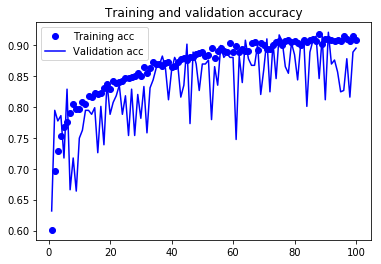

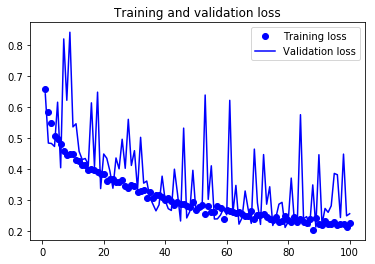

In [28]:
plot_loss_acc_graph(history2)

## Discussion

From the graphs we can notice the following:
* The validation graphs now are more alligned with the training graphs, which is a sign of less overfitting.
* The validation graphs reache higher values of accuracy and lower values of loss in the advanced epochs, so the performance has enhanced (the accuracy starts reaching 0.9 after 70 epochs).
* However, the validation graphs tend to fluctuate, which means that even in advanced epochs sometimes the classifier miss classify samples. Generally, smoother graphs are better because they reflect models that have more prdictable behavior on unseen data.
* The data augmentation might solved the problem of overfitting, but the classifier still has unpredictable behavior.
* This lead me to think that the network architecture is not suitable enough for this dataset.

Adjusting the network architecture manually is a very challenging and inefficient solution. Instead we can use pretrained networks. This solution is very effiective on small image datasets like this one. I will explore this option in the next section.

# Third approach: using a pretrained CNN

Pretrained networks are saved networks (i.e. architecture + weights) already trained on a large dataset. Some of these netwroks are trained on generic datasets with many objects and scenes at a point that the learned spatial features hierarchy can be considered as a generic model of the visual world. So these visual features can be used to solve other computer vision tasks even if they deal with completely different classes or usecases.

In this approach I will use a pre-trained newtork packaged with Keras to extract features from the images and then train a classifier on top of the output of the network. The convolutional base (i.e. the sequence of pooling and convolution layers in a network) is used for the feature extraction.

Here I will be using the VGG16 packaged with Keras along with other networks (e.g. Xception, ResNet...). VGG16 is a network trained on ImageNet and knowing to yeld good features for image classification.

In [54]:
# Loading the VGG16 convolutional base, with its weights, excluding the top dense layer for classification.
# We also specify the input-shape to be conform with the input_shape we used in the previous models to allow fair comparision of te preformance

from keras.applications import VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [55]:
vgg16_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

**We can notice that the finale layer output shape is (4,4,512), and I will add a densly connected classifier on top of it.**

In [56]:
import numpy as np

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # prepare the array for the features of all images in a directory
    labels = np.zeros(shape=(sample_count)) # prepare the array for the labels
    generator = datagen.flow_from_directory(directory, 
                                            target_size=(150, 150), 
                                            batch_size=batch_size, 
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg16_base.predict(inputs_batch) # we use the vgg16_base predict to extract features
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count: # the generator generate data infinitly to we need to stop it once we process all the images in the directory
            break
    return features, labels

In [57]:
train_features, train_labels = extract_features(train_dir, train_samples_num-(train_samples_num%batch_size))
validation_features, validation_labels = extract_features(validation_dir, val_samples_num-(val_samples_num%batch_size))
test_features, test_labels = extract_features(test_dir, test_samples_num-(test_samples_num%batch_size))

Found 3225 images belonging to 2 classes.
Found 403 images belonging to 2 classes.
Found 404 images belonging to 2 classes.


In [63]:
# We need to flatten the extracted features in order to pass it to a densly connected classifier.

train_features = np.reshape(train_features, (train_samples_num-(train_samples_num%batch_size), 4 * 4 * 512))
validation_features = np.reshape(validation_features, (val_samples_num-(val_samples_num%batch_size), 4 * 4 * 512))
test_features = np.reshape(test_features, (test_samples_num-(test_samples_num%batch_size), 4 * 4 * 512))

In [65]:
# Now we build and train a densly connected classifier on the features extracted in the previous three cells
# A dropout layer is added as well to avoid overfitting.

from keras import models
from keras import layers
from keras import optimizers

model3 = None

model3 = models.Sequential()
model3.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history3 = model3.fit(train_features,
                     train_labels,
                     epochs=50,
                     batch_size=32, 
                     validation_data=(validation_features, validation_labels))

Train on 3200 samples, validate on 384 samples
Epoch 1/50
3200/3200 [==============================] - 3s 815us/step - loss: 0.5703 - acc: 0.7013 - val_loss: 0.4024 - val_acc: 0.8542
Epoch 2/50
3200/3200 [==============================] - 1s 210us/step - loss: 0.3842 - acc: 0.8366 - val_loss: 0.3227 - val_acc: 0.8802
Epoch 3/50
3200/3200 [==============================] - 1s 208us/step - loss: 0.3057 - acc: 0.8834 - val_loss: 0.2851 - val_acc: 0.8854
Epoch 4/50
3200/3200 [==============================] - 1s 209us/step - loss: 0.2650 - acc: 0.8972 - val_loss: 0.2669 - val_acc: 0.8906
Epoch 5/50
3200/3200 [==============================] - 1s 207us/step - loss: 0.2376 - acc: 0.9100 - val_loss: 0.2490 - val_acc: 0.9036
Epoch 6/50
3200/3200 [==============================] - 1s 209us/step - loss: 0.2183 - acc: 0.9119 - val_loss: 0.2450 - val_acc: 0.9036
Epoch 7/50
3200/3200 [==============================] - 1s 208us/step - loss: 0.2030 - acc: 0.9256 - val_loss: 0.2291 - val_acc: 0.9062
E

## Plotting the training/validation accuracy and loss graphs

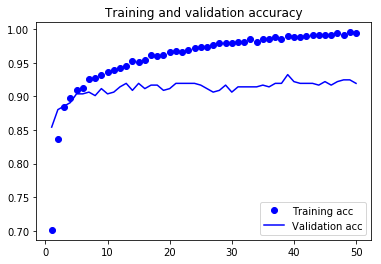

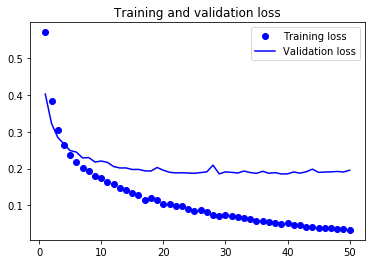

In [66]:
plot_loss_acc_graph(history3)

## Discussion

* From the graphs we can see that the validation graph are much more smoother with higher accuracy and lower loss than the previous appraoch.
* True that the accuracy is not much higher but it can be statistically significant (a test like wilcoxon statistial significant test can be applied to check if a graph is consistantly higher than another).
* The main advantage here is that the model is much more stable and its behaviour is more predictiable. Thus, I believe it is more generalisable.

Let's try the same approach with data augmentation to see if we can gain more in term of accuracy.

# Forth Model: Feature Extraction with Data Augmentation

This is very similar to the second model buit previsouly, except that in order to use the features of the vgg16 model, we insert it as a first layer in a new newtrok as shown in the next cell.

In [67]:
model4 = models.Sequential()
model4.add(vgg16_base)
model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

In [68]:
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [69]:
vgg16_base.trainable = False # we freez the training for the vgg16_base layers so the training will affect only the other layers

In [70]:
train_datagen4 = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

test_datagen4 = ImageDataGenerator(rescale=1./255)

In [71]:
train_generator4 = train_datagen4.flow_from_directory(train_dir,
                                                      target_size=(150, 150),
                                                      batch_size=32,
                                                      class_mode='binary')

validation_generator4 = test_datagen4.flow_from_directory(validation_dir,
                                                          target_size=(150, 150),
                                                          batch_size=15,
                                                          class_mode='binary')

model4.compile(loss='binary_crossentropy',
               optimizer=optimizers.RMSprop(lr=2e-5),
               metrics=['acc'])

history4 = model4.fit_generator(train_generator4,
                               steps_per_epoch=100,
                               epochs=100,
                               validation_data=validation_generator4,
                               validation_steps=50,
                                use_multiprocessing=True,
                                workers=8)

Found 3225 images belonging to 2 classes.
Found 403 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 33s 326ms/step - loss: 0.5496 - acc: 0.7231 - val_loss: 0.4031 - val_acc: 0.8382
Epoch 2/100
Epoch 1/100
100/100 [==============================] - 29s 291ms/step - loss: 0.4148 - acc: 0.8301 - val_loss: 0.3315 - val_acc: 0.8690
Epoch 3/100
100/100 [==============================] - 29s 293ms/step - loss: 0.3680 - acc: 0.8493 - val_loss: 0.2867 - val_acc: 0.8930
Epoch 4/100
100/100 [==============================] - 29s 290ms/step - loss: 0.3312 - acc: 0.8649 - val_loss: 0.2636 - val_acc: 0.8890
Epoch 5/100
100/100 [==============================] - 29s 292ms/step - loss: 0.3229 - acc: 0.8591 - val_loss: 0.2565 - val_acc: 0.9131
Epoch 6/100
100/100 [==============================] - 29s 293ms/step - loss: 0.2976 - acc: 0.8796 - val_loss: 0.2423 - val_acc: 0.8984
Epoch 7/100
100/100 [==============================] - 29s 293ms/step - loss: 0.2823 - ac

## Plotting the training/validation accuracy and loss graphs

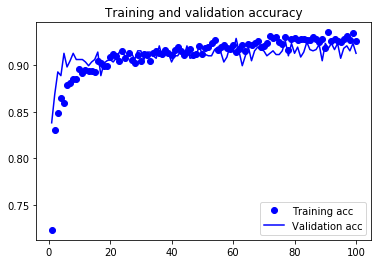

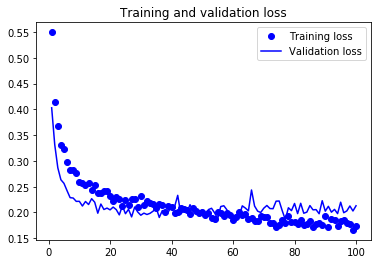

In [72]:
plot_loss_acc_graph(history4)

## Discussion

Here we notice that we reach a level of performance where the training and validation accuarcy and loss are close to each others allover the epochs, and the fluctuation of the validation graphs is less than in the first augmented model.

We can probably here say that this model is preidcable and more generalisable than the others.

Let's run the four models on the test set to check their generalisation power.

# Running the for models on the test set

Let's compare the 4 models in term of accuracy on the test set.

In [99]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=32,
                                                  class_mode='binary')

test_results_list = []

test_results_list.append(["model1"]+(model.evaluate_generator(test_generator, steps=15)))
test_results_list.append(["model2"]+(model2.evaluate_generator(test_generator, steps=15)))
test_results_list.append(["model3"]+(model3.evaluate(test_features, test_labels)))
test_results_list.append(["model4"]+(model4.evaluate_generator(test_generator, steps=15)))

Found 404 images belonging to 2 classes.
384/384 [==============================] - 0s 104us/step


In [100]:
import pandas as pd

# helper function to highlight the maximum in a Series yellow.
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

test_results = pd.DataFrame.from_records(test_results_list)
test_results.columns = ["Model", "Loss", "Accuracy"]

In [108]:
test_results.style.apply(highlight_max, subset=['Accuracy'])

,Model,Loss,Accuracy
0,model1,1.61217,0.754274
1,model2,0.391263,0.865385
2,model3,0.198717,0.921875
3,model4,0.213744,0.912393


## Discussion

* From the table above we notice that the third model (feature extraction using pre-trained CNN) has the best accuracy
* I expected model4 to be more generalisable, which can still be the case as the accuracies of model3 and model4 are very close.
* Model1 and model2 has much lower accuracy on the testset.
* Note that in term of loss function model1 is the best one followed by model3 then model4 then model2.
* Considering both values (loss and accuracy), model3 can be considered as the best classifier among the other three for this dataset.

# Final Remarks

* In this notebook I have built and compared four binary classifiers for chickens and cows images.
* Using pre-trained CNN is beneficial and lead to better results.
* Data augmentation might not always give the best results, but it has the advantage of being less prone to overfitting and yiel more predicable classifiers (no much fluctuation in the validation graphs).

* Further enhancement can be acheived by fine tuning as an extension to the pre-trained approaches.
In fine tuning we de-freez some of the layer of the pre-trained network and we re-train their parameter, this can lead to even better classifiers, but some i can be a time consuming process.
* The hyper parameters can be optimsed to get better results, namely the learning rate. Few learning rates can be tested.

* The resizing to 150 x 150 pixels images can distort the images, and different resizing strategies can be tested.
I have tested a crop_and_pad function as described here: https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/, but this didn't lead to better results. More investigations are necessary here.